# IN3062 – Introduction to Artificial Intelligence

## *Coursework Notebook*

#### Sever Miranbeg, Akif Karakus, Moeen Younis

# Introduction

This notebook documents analysis done on a [dataset](https://www.kaggle.com/mirichoi0218/insurance) collating records of anonymous individuals in the US on health insurance premiums in order to produce a model predicting the cost of a healthcare package for a single person based on several factors, some of which include their **age**, **gender** and [**BMI**](https://en.wikipedia.org/wiki/Body_mass_index) value.

## Reading in the data

Firstly, we import the required [`os`](https://docs.python.org/3.8/library/os.html) and [`pandas`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/index.html) modules in order to load the CSV file (`healthcare.csv`) containing the our data and create a new [`DataFrame`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/frame.html) object. The [`head`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.head.html) function is then used to display the object's columns and first 5 rows.

In [1]:
# Required imports
import os
import pandas as pd

# Reads in CSV to initialize a DataFrame, then outputs the first 5 rows
path = "../data/"
read = os.path.join(path, "healthcare.csv")
df = pd.read_csv(read)
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


Referencing the [`shape`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.shape.html) property of our `DataFrame` object returns a tuple representing its dimensions (number of rows by number of columns).

In [2]:
df.shape    # Returns the dimensions (rows, cols)

(1338, 7)

As shown above, there are 1338 rows (observations) in addition to 7 columns (features) to work with, which is sufficient to build a reliable model. The following section covers the steps taken to prepare the data for training.

## Preprocessing the data

Data preprocessing is essential in machine learning, as it ensures consistency in the data and relevant information used by a model, subsequently improving its ability to learn.

Almost all datasets present in the real world contain some discrepancies, requiring us to identify missing data. In the case of our dataset, NA/null values are represented by `NaN`. This can be done by calling either [`isna`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.isna.html) or [`isnull`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.isnull.html), which both produce the same output.

In [3]:
df.isna()    # Is each cell NA/null?

,age,sex,bmi,children,smoker,region,charges
0,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
1333,False,False,False,False,False,False,False
1334,False,False,False,False,False,False,False
1335,False,False,False,False,False,False,False
1336,False,False,False,False,False,False,False


For a clearer summary of any NA/null values in the dataset, calling [`sum`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.sum.html) immediately after `isna` or `isnull` will calculate the number of `NaN` values found under each column in a given `DataFrame` object, as shown below.

In [4]:
df.isnull().sum()    # Outputs the number of NA/null values under each column

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

To retrieve relevant statistics (mean, ranges, quartiles, standard deviation) we made use of [`describe`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.describe.html). Non-numeric columns (`sex`, `smoker`, `region`) are excluded by default.

In [5]:
df.describe()    # Summary stats

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


From the figures above, we see that:
- The average cost of a health insurance plan for an individual is 13,720 USD whilst the standard deviation lies at 12,110 USD.
    - This suggests that costs are fairly dispersed due to the relatively small difference between both values.
- The cheapest plan costs 1,122 USD in comparison to the most expensive at 63,770.
- The average age is 39, the youngest being 18 and the oldest 64.
- The average BMI value falls at around 31 with a standard deviation of 6.
    - This indicates that the spread in BMI values amongst individuals in the dataset is relatively small.
    
As a final step in preprocessing the data, we must convert categorical variables in the dataset into dummy or indicator variables. This is required as regression doesn't allow the use of non-numerical values in its model. We can see in the previous code block that the columns (features) `sex`, `smoker` and `region` were not included in the [`describe`](https://pandas.pydata.org/pandas-docs/version/1.3.3/reference/api/pandas.DataFrame.describe.html) function. 

We can make use of another function provided by the `pandas` library called [`get_dummies`](https://pandas.pydata.org/docs/reference/api/pandas.get_dummies.html) which preprocesses the non-numerical columns into data that the regression model can make use of. This is preferable as the more features the model is able to work with, the better prediction it is able to make.

In [6]:
df = pd.get_dummies(df)    # Converts non-numerical columns into dummy/indicator columns
df.head()

,age,bmi,children,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,27.900,0,16884.92400,1,0,0,1,0,0,0,1
1,18,33.770,1,1725.55230,0,1,1,0,0,0,1,0
2,28,33.000,3,4449.46200,0,1,1,0,0,0,1,0
3,33,22.705,0,21984.47061,0,1,1,0,0,1,0,0
4,32,28.880,0,3866.85520,0,1,1,0,0,1,0,0


## Prediction using a Linear Regression Model

Now that our data has been cleaned and preprocessed, we'll make use of [`sklearn`](https://scikit-learn.org/stable/modules/classes.html) (another resourceful machine learning library for Python) to produce a [linear regression model](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html). We must first define `X` and `y`, which represent the feature and target data respectively.

In [7]:
X = df[[x for x in df.columns if not "charges" in x]].values    # Collect the values for all non-target features
y = df["charges"].values                                        # Collect the values for the target feature

Now that we have the feature and target data, we can split the data into training and testing using [`train_test_split`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html?highlight=train%20test%20split#sklearn.model_selection.train_test_split) data, followed by a call to [`fit`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html#sklearn.linear_model.LinearRegression.fit) on our linear regression model.

In [8]:
%%capture
# Required imports
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression

# Split the data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=909) 

# Builds the model and fits the training data
model = LinearRegression()
model.fit(X_train, y_train)

Now that we have built and trained the model, we can produce a prediction using the [`predict`]() function. Later on, we'll be comparing these values against the actual values, which are stored in `y_test`.

In [9]:
y_pred = model.predict(X_test)    # Produces a prediction and outputs the first 5 values
y_pred[0:5]

array([ 1438.80623973, 12311.61386309, 39791.84553191,  6868.70742296,
       24537.21893189])

With our prediction in place, we can calculate the mean of the values and the root squared mean error (RMSE) which would give us an indication on the accuracy of the regression model.

In [10]:
# Required imports
import numpy as np
from sklearn import metrics

# Outputs of calculated values in relation to prediction
mean = np.mean(y_test)
print(f">>        Mean: {mean}")
print(f">>        RMSE: {np.sqrt(metrics.mean_squared_error(y_test, y_pred))}")
print(f">> 10% of Mean: {mean*0.1}")

>>        Mean: 12607.678939074629
>>        RMSE: 5539.9913458334395
>> 10% of Mean: 1260.767893907463


As we know, 10% (or less) of the mean is considered a good score for the RMSE value. However, we can see that our model has produced an RMSE value much higher than this.

## Visualizing initial predictions

To visualize results we'll be using [`matplotlib`](https://matplotlib.org/3.4.3/api/index.html) and [`seaborn`](https://seaborn.pydata.org/api.html) which are both data visualization libraries for Python. The [`regplot`](https://seaborn.pydata.org/generated/seaborn.regplot.html) function takes in a `DataFrame` object (initialized with our test subset and predicted values) and plots the corresponding regression model.

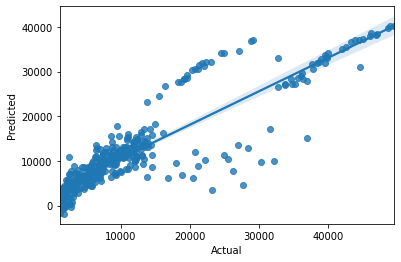

In [11]:
# Required imports
import seaborn as sns

# Plots and locally saves a DataFrame of the actual against predicted values
fig = sns.regplot(x="Actual", y="Predicted", data=pd.DataFrame({"Actual": y_test, "Predicted": y_pred}))
fig
fig.get_figure().savefig("../models/linreg_fig01.png")

As shown in the graph, we have a considerable amount of outliers that are not in correlation with the rest of the model. In order to handle this we shall apply standardization (also known as normalisation) using the scikit-learn library; this is necessary in order to avoid bias in the outcome. 